### Agents SDK tests

Goal: test o3 with tool calling capabilties

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

import json
import yaml
from datetime import datetime
from IPython.display import Markdown

from tqdm.asyncio import tqdm


from openai import AsyncOpenAI
openai_client = AsyncOpenAI()

import tiktoken
encoding = tiktoken.get_encoding("o200k_base")
def count_tokens(msg):
    return len(encoding.encode(msg))

# agents sdk
from agents import Agent, Runner, WebSearchTool, function_tool, ModelSettings
from agents.model_settings import Reasoning
from agents.extensions.visualization import draw_graph

Quick test with Agents SDK

In [4]:
def pretty_print_agent_run_events(agent_run_response, display_last_step=False):
    
    for e, i in enumerate(agent_run_response.new_items):
        print("\n" + "=" * 60)
        print(f"✨ Step {e+1}: {i.type} ✨")
        print("=" * 60 + "\n")

        if i.type == 'message_output_item':
            #print(f"Output: {i.raw_item.content[0].text}")
            print("📝 Output:")
            if display_last_step:
                display(Markdown(i.raw_item.content[0].text))
            else:
                print(i.raw_item.content[0].text)
        
        else:
            print("📝 Output:")
            print(f"{i.raw_item}")

        print("\n")

def count_agent_run_event_types(agent_run_response):
    """Counts the different types of events in an agent run response."""
    from collections import Counter
    
    event_counts = Counter()
    for item in agent_run_response.new_items:
        event_counts[item.type] += 1
    return dict(event_counts)

In [5]:
@function_tool  
async def divide(a: float, b: float) -> float:
    """Divide two numbers"""
    return a / b

@function_tool  
async def multiply(a: float, b: float) -> float:
    """Multiply two numbers"""
    return a * b

In [6]:
async def main(agent, user_input):
    result = await Runner.run(agent, user_input)
    return result

agent = Agent(
    name="Financial analyst", 
    instructions="You are a helpful assistant specializing in financial analysis and numbers.", #system message
    model = "o3",
    model_settings=ModelSettings(reasoning=Reasoning(effort="high")),
    tools=[divide, multiply],
    )

In [7]:
user_input = "What is 156800 divided by 12 and then multiplied by 1000?"
result = await Runner.run(agent, user_input)

In [8]:

print(result.final_output)

156 800 ÷ 12 = 13 066.666 666 667  
13 066.666 666 667 × 1 000 = 13 066 666.666 667

Rounded to two decimal places: 13 066 666.67


In [9]:
pretty_print_agent_run_events(result)


✨ Step 1: reasoning_item ✨

📝 Output:
ResponseReasoningItem(id='rs_682b5c45d598819880d17358aef59d480def319d01b767f3', summary=[], type='reasoning', encrypted_content=None, status=None)



✨ Step 2: tool_call_item ✨

📝 Output:
ResponseFunctionToolCall(arguments='{"a":156800,"b":12}', call_id='call_YYKPVYfue1BALL7hAxYilSUC', name='divide', type='function_call', id='fc_682b5c589e088198924851f0431412290def319d01b767f3', status='completed')



✨ Step 3: tool_call_output_item ✨

📝 Output:
{'call_id': 'call_YYKPVYfue1BALL7hAxYilSUC', 'output': '13066.666666666666', 'type': 'function_call_output'}



✨ Step 4: tool_call_item ✨

📝 Output:
ResponseFunctionToolCall(arguments='{"a":13066.666666666666,"b":1000}', call_id='call_Lr2asvEmTLFzRwEUMhsmZJda', name='multiply', type='function_call', id='fc_682b5c5bfa9881988f9c4dcc3b67b3e20def319d01b767f3', status='completed')



✨ Step 5: tool_call_output_item ✨

📝 Output:
{'call_id': 'call_Lr2asvEmTLFzRwEUMhsmZJda', 'output': '13066666.666666666', 'type'

Try web tool

In [26]:
@function_tool  
async def web_search(query: str) -> str:
    """Search the web for information"""

    agent = Agent(
        name="Web search agent", 
        instructions="You are a helpful assistant specializing in web search.", #system message
        model = "gpt-4.1",
        model_settings=ModelSettings(temperature=0.0),
        tools=[WebSearchTool()],
        )
    
    result = await Runner.run(agent, query)
    
    return result.final_output

In [27]:
agent = Agent(
    name="Financial analyst", 
    instructions="You are a helpful assistant specializing in financial analysis and numbers.", #system message
    model = "o3",
    model_settings=ModelSettings(reasoning=Reasoning(effort="high")),
    tools=[divide, multiply, web_search],
    )

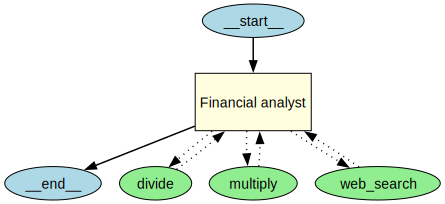

In [29]:
draw_graph(agent, '../output/agents_sdk_experiments/web_search_agent_graph')


In [16]:
user_input = "What is the current price of Bitcoin? Multiple that by the current market cap of Tesla, then divide by 1000"
result = await Runner.run(agent, user_input)

In [17]:
print(result.final_output)

Here are the requested figures (all values in U.S. dollars):

1. Current Bitcoin price: ≈ $104,818  
2. Tesla market capitalization: ≈ $1.06 trillion

Multiply Bitcoin’s price by Tesla’s market cap:  
$104,818 × $1.06 trillion ≈ $1.111 × 10^17

Divide that product by 1,000:  
($1.111 × 10^17) ÷ 1,000 ≈ $1.11 × 10^14  
≈ $111,107,080,000,000 (about $111.1 trillion)


In [18]:
pretty_print_agent_run_events(result)


✨ Step 1: reasoning_item ✨

📝 Output:
ResponseReasoningItem(id='rs_682b5cbd47d08198a8d3c77a81dff4b10875f4b70802eb8b', summary=[], type='reasoning', encrypted_content=None, status=None)



✨ Step 2: tool_call_item ✨

📝 Output:
ResponseFunctionToolCall(arguments='{"query":"Current price of Bitcoin in USD"}', call_id='call_zntf9BHAZShavUPErgznLJW8', name='web_search', type='function_call', id='fc_682b5ccabb448198a8ec8ee58d992f9d0875f4b70802eb8b', status='completed')



✨ Step 3: tool_call_output_item ✨

📝 Output:
{'call_id': 'call_zntf9BHAZShavUPErgznLJW8', 'output': 'As of May 19, 2025, at 4:31 PM, the current price of Bitcoin (BTC) is approximately $104,818 USD.\n\n## Stock market information for Bitcoin (BTC)\n- Bitcoin is a crypto in the CRYPTO market.\n- The price is 104818.0 USD currently with a change of -579.00 USD (-0.01%) from the previous close.\n- The intraday high is 106540.0 USD and the intraday low is 102381.0 USD.\n\n\nPlease note that cryptocurrency prices are highly vol

### Deep Research test
o3 + 4.1-web 

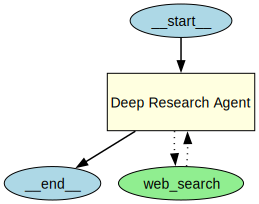

In [30]:
@function_tool  
async def web_search(query: str) -> str:
    """Tool for conducting targeted web searches. Use this tool to find information to answer specific questions or to gather data for research.
    It can be called multiple times to explore different aspects of a query or to refine search results.

    Args:
        query: A specific natural language question, research question or search term.

    Returns:
        A string containing the search results.
    """

    agent = Agent(
        name="Web search agent", 
        instructions="You are a helpful assistant specializing in web search.", #system message
        model = "gpt-4.1",
        model_settings=ModelSettings(temperature=0.0),
        tools=[WebSearchTool()],
        )
    
    result = await Runner.run(agent, query)
    
    return result.final_output

agent = Agent(
    name="Deep Research Agent", 
    instructions="You are a Deep Research Agent. Your primary function is to conduct thorough investigations based on user-provided research task. You must meticulously plan your research, breaking down complex topics into a series of targeted web searches using the 'web_search' tool. Execute multiple searches as needed to gather comprehensive information. Finally, synthesize all findings into a detailed and coherent answer to the user's request.", 
    model = "o3",
    model_settings=ModelSettings(reasoning=Reasoning(effort="high")),
    tools=[
        web_search
        ],
    )

draw_graph(agent, "../output/agents_sdk_experiments/deep_research_agent_graph")

In [20]:
research_topic = """
I need a thorough analysis of n8n, an agentic workflow design SaaS, and its alternatives. 
This analysis should cover:
1.  A detailed overview of n8n: its core features, capabilities, and typical use cases.
2.  Identification and detailed overview of key alternatives to n8n in the agentic pattern design and workflow automation space.
3.  A comparative analysis of n8n and its alternatives, focusing on:
    *   Key differentiators (e.g., ease of use, pricing, integration capabilities, community support, specific features for agentic patterns).
    *   Strengths and weaknesses of each platform.
    *   Specific capabilities related to designing, building, and deploying agentic patterns or workflows.
4.  Any other relevant information that would help in understanding the landscape of these tools.
The goal is to produce a comprehensive report that allows for an informed decision when choosing a platform for agentic pattern design and automation.
"""

user_message = f"""
<research_objective>
Your primary objective is to conduct thorough research.
You are expected to use the 'web_search' tool multiple times to gather comprehensive information relevant to the research topic.
Synthesize your findings into a detailed and well-structured report.
</research_objective>

<research_topic>
Conduct deep research on the following topic:
{research_topic}
</research_topic>
"""

In [21]:
MAX_TURNS = 99
result = await Runner.run(agent, user_message, max_turns=MAX_TURNS)

42 minute run!

In [22]:
display(Markdown(result.final_output))

Comprehensive Report: n8n and the Agentic-Workflow Automation Landscape (mid-2025)

────────────────────────────────────────
A.  n8n—Deep-Dive
────────────────────────────────────────
1. Product DNA  
   • Category: Visual workflow/automation builder (low-code) that also exposes every workflow as a REST endpoint—making it usable as an orchestration layer for AI “agents”.  
   • Licence / Delivery: Source available under the Sustainable-Use (Fair-Code) licence. 100 % free if you self-host; commercial restrictions only apply if you resell the product itself. Cloud SaaS is fully managed by n8n GmbH.  
   • Tech stack: Node.js, TypeScript; workflows stored in Postgres; each “node” is an independent JS module.  
   • Community: ≈35 k GitHub ★, >15 k Slack/forum users, >400 community-supplied nodes.

2. Core Feature Set  
   • Visual, node-based builder with unlimited branches, cycles, error paths, and sub-workflows (“child workflows”).  
   • 400 + ready-made nodes: SaaS apps (Salesforce, Stripe, Slack), DBs, queues, e-mail, file systems, and specialised AI nodes (OpenAI, Anthropic, HuggingFace, Replicate).  
   • “Function/Code” node—inline JS, enabling bespoke logic, vector-store calls, etc.  
   • Triggers: Cron, Webhook, Event Stream, Polling, Queue, UI Form.  
   • Data handling: built-in parsers (CSV, XML, HTML), binary file routing, item-by-item or batch processing, looping, IF/Switch, Merge, Split, Wait/Delay, Try-Catch.  
   • AI/Agentic primitives (2023-24 releases):  
     – AI Agent node (think/plan/act, chat memory, tool calling).  
     – Templates for “Think-Plan-Act”, autonomous chat-bots, and “Proxmox AI Admin”.  
     – Prompt engineering helpers, JSON mode, function-calling schema generator.  
   • Ops features: role-based access, separate dev/stage/prod envs (Enterprise), Git-based workflow versioning, log streaming, external secret store (Vault), SAML/LDAP SSO.  
   • Deployment footprints: Docker, k8s helm chart, n8n-cloud; execution scaling via queue-mode workers.

3. Typical Use Cases (illustrative)  
   • Marketing & RevOps: enrich leads → qualify with GPT sentiment → write intro email → update HubSpot.  
   • LLM Agents: Telegram chat bot that transcribes voice (Whisper) → calls GPT-4o → triggers Jira tasks.  
   • DevOps: daily Slack stand-up summariser → aggregate GitHub PRs → run LangChain agent to extract blockers.  
   • Data engineering: S3 ingest → cleanse via JS function → embed with OpenAI → upsert Pinecone.  

4. Commercials (Cloud, May-2025)  
   • Starter $24/m (2 500 execs, 5 workflows) • Pro $60/m (10 k execs, 15 workflows) • Enterprise – custom; unlimited execs & self-host support.

5. Strengths / Watch-outs  
   ✓ Unlimited complexity (loops, recursion, inline code).  
   ✓ First-class self-hosting; data never leaves your infra.  
   ✓ Fast-moving AI roadmap, thriving template gallery.  
   ✗ Smaller turnkey-integration catalog than Zapier/Tray.  
   ✗ Fair-Code licence forbids re-selling a hosted version.  
   ✗ Needs DevOps familiarity for production-grade scaling.

────────────────────────────────────────
B.  Principal Alternatives
────────────────────────────────────────
1. Zapier  
   • Closed-source, cloud-only, >7 000 apps.  
   • “AI Actions” ChatGPT plug-in, natural-language builder, Paths, Loops, but no custom code execution beyond webhooks.  
   • Pricing: Free 100 tasks → Team $69 + /m → Enterprise custom.  
   • Target: business users who want dead-simple automations.

2. Make (née Integromat)  
   • Visual canvas with bubbles/lines; >1 000 apps; supports routers, iterators, aggregation.  
   • No built-in LLM agent primitives yet; can call any HTTP/AI API.  
   • Self-host not available.  Free 1 000 ops → Core $9/m → Teams $29 +.  
   • Strength: fine-grained data mapping, granular error handling.

3. Node-RED  
   • OSS (Apache-2). Initially IoT-centric; now >4 000 nodes.  
   • Excellent for hardware/MQTT/edge; JS-function node for anything.  
   • No SaaS; you run it yourself or via third-party hosts ($5–15/m).  
   • Security diligence required (community nodes, CVE record).

4. Pipedream  
   • Serverless integration platform for developers (JS/Python code steps).  
   • 1 000s of pre-built “actions”; cron, event streams.  
   • AI: user writes code calling OpenAI; no drag-and-drop agent UI.  
   • Free 100 k invocations with rate limits; paid from $19/m.

5. Tray.io / Tray.ai  
   • Enterprise-grade low-code iPaaS; “Merlin AI” natural-language flow builder; AI-augmented API mgmt.  
   • Hundreds of connectors, callable sub-workflows, SSO, SOC2.  
   • Pricing undisclosed; reportedly mid-four-figure €/year starting.

6. Activepieces (OSS)  
   • MIT licensed, self-host or cloud ($10/m).  
   • 200 + connectors, drag-and-drop, OpenAI piece, IF/Loop, retries.  
   • Embeddable white-label builder for SaaS vendors.  
   • Community smaller but growing quickly.

7. Automatisch (OSS)  
   • GPL; self-host free, or hosted single-user €20/m.  
   • Modern UI, unlimited flows, tasks; ≈100 connectors.  
   • LLM integration via generic HTTP—no native agent features yet.

8. Flowise  
   • OSS visual LangChain builder—specialised in LLM/agent chains.  
   • Drag-and-drop prompts, memory, tools; export as REST API.  
   • Complements, rather than replaces, general-purpose automation.

9. LangFlow  
   • Similar to Flowise; real-time debug, custom component SDK.  
   • Focus exclusively on LLM pipelines—pairs well with n8n/Zapier for non-AI tasks.

────────────────────────────────────────
C.  Head-to-Head Comparison Matrix (abridged)
────────────────────────────────────────
Legend: ✔ native / ○ possible via code / ✕ not offered

Platform            | OSS? | Self-host | #Connectors | Loops & Branches | Inline Code | Native AI-Agent Node | Natural-Language Flow Builder | Pricing (entry)
-------------------------------------------------------------------------------------------------------------------------------------------
n8n                 | Fair | ✔         | ~400        | ✔ Unlimited      | ✔ JS        | ✔ (AI Agent)         | Roadmap (AI prompt builder)  | Free self-host / $24 cloud
Zapier              | ✕    | ✕         | 7 000 +     | ✔ (Paths)        | ✕           | ○ (via ChatGPT plug-in) | ✔ (“describe your Zap…”)     | Free / $19.99 +
Make                | ✕    | ✕         | 1 000 +     | ✔ (Routers)      | ✕           | ○ (HTTP modules)     | ✕ (AI missing)               | Free / $9 +
Node-RED            | ✔    | ✔         | 4 000 +     | ✔                | ✔ JS        | ○ (OpenAI contrib)   | ✕                            | Free
Pipedream           | Partial | ✕      | 1 000 +     | Code-based       | ✔ JS/Py     | ○                   | ✕                            | Free / $19 +
Tray.ai             | ✕    | ✕         | 600 +       | ✔                | Low-code    | ○ (“Merlin AI” tools)| ✔ (Merlin)                   | $$$ (enterprise)
Activepieces        | ✔    | ✔         | 200 +       | ✔                | ✕           | ○ (OpenAI piece)     | ✕                            | Free / $10 +
Automatisch         | ✔    | ✔         | 100 +       | ✔                | ✕           | ✕                   | ✕                            | Free / €20 +
Flowise / LangFlow  | ✔    | ✔         | N/A (LLM)   | ✔ (agent chains) | Low-code    | ✔ (agents core)      | ✕                            | Free

────────────────────────────────────────
D.  Key Differentiators & Decision Drivers
────────────────────────────────────────
1. Hosting / Data Residency  
   • Need on-prem or VPC? → n8n, Node-RED, Activepieces, Automatisch, Flowise.  
   • Comfortable with vendor cloud? → Zapier, Make, Tray.

2. Depth of Agentic Capabilities  
   • Built-in think-plan-act, chat memory, tool calling → n8n (strong), Flowise, LangFlow.  
   • Generic AI calls only → Zapier, Make, Pipedream, Activepieces.  
   • No AI primitives → Automatisch (yet).

3. Integration Breadth  
   • “I just want it to connect to anything without coding” → Zapier or Tray.  
   • Willing to build/extend connectors → n8n (SDK), Node-RED (npm).

4. Complexity vs Simplicity  
   • Business-user autopilot → Zapier Paths + AI Actions, Make visual router.  
   • Power-user / developer orchestration → n8n, Pipedream, Node-RED.

5. TCO / Licensing Philosophy  
   • Zero licence fees, own infra → n8n self-host, Node-RED, Activepieces.  
   • Managed service, predictable spend → n8n-Cloud, Make, Zapier, Tray.

6. Ecosystem & Community Support  
   • Largest community tutorials/snippets → Zapier (non-code) & n8n (code).  
   • Agent-research/LLM-enthusiast community → Flowise / LangFlow.

────────────────────────────────────────
E.  Recommendations
────────────────────────────────────────
• If your priority is end-to-end agentic automation with full control over data, open extensibility, and a vibrant AI template gallery—n8n is currently the most balanced choice.  
• Pair n8n with Flowise or LangFlow when you need advanced prompt-engineering and RAG chains but still want orchestration, error handling, and scheduling.  
• Choose Zapier for quick, shallow automations where speed of connector availability outranks deep logic or self-hosting.  
• Make is compelling for non-AI, data-heavy multi-branch automations where cost per operation is sensitive.  
• Node-RED remains unbeatable in hardware/edge and for engineers comfortable writing JS functions.  
• Activepieces and Automatisch are emerging OSS options worth piloting if licensing freedom or white-labelling is paramount and you can tolerate a smaller connector set.  
• Tray.ai fits enterprises seeking low-code + AI co-pilot plus enterprise-grade governance, but budget accordingly.

────────────────────────────────────────
F.  Quick-Start Evaluation Checklist
────────────────────────────────────────
1. Data Location / Compliance requirements?  
2. Number & type of SaaS systems to integrate?  
3. Do workflows need loops, recursion, or code?  
4. Are autonomous LLM agents central or peripheral?  
5. Expected monthly task volume → cost modelling.  
6. Internal skill-set: business ops vs developers vs DevOps.  
7. Road-map fit: open-source flexibility vs turnkey SaaS speed.

Use the matrix and the checklist together to shortlist (typically two) candidates and run a proof-of-concept with a representative, AI-powered workflow.

In [23]:
output_dir = "../output/agents_sdk_experiments"
os.makedirs(output_dir, exist_ok=True)

file_path = os.path.join(output_dir, "deep_research_report_o3_X_gpt41_n8n_research.md")
with open(file_path, "w") as f:
    f.write(result.final_output)

print(f"Report saved to {file_path}")

Report saved to ../output/agents_sdk_experiments/deep_research_report_o3_X_gpt41_n8n_research.md


In [24]:
count_agent_run_event_types(result)

{'reasoning_item': 26,
 'tool_call_item': 27,
 'tool_call_output_item': 27,
 'message_output_item': 1}

In [25]:
pretty_print_agent_run_events(result)


✨ Step 1: reasoning_item ✨

📝 Output:
ResponseReasoningItem(id='rs_682b5fb817988198bf59e29b9c7b326a0b98ae04f47a0cca', summary=[], type='reasoning', encrypted_content=None, status=None)



✨ Step 2: tool_call_item ✨

📝 Output:
ResponseFunctionToolCall(arguments='{"query": "n8n features workflow automation nodes triggers AI integration pricing 2024"}', call_id='call_sB1Zqr7tOBlGmcfM1NGRkfXb', name='web_search', type='function_call', id='fc_682b5fc8e7d481988ceff5e99ab9a4320b98ae04f47a0cca', status='completed')



✨ Step 3: tool_call_output_item ✨

📝 Output:
{'call_id': 'call_sB1Zqr7tOBlGmcfM1NGRkfXb', 'output': "n8n is an open-source workflow automation tool that enables users to connect various applications and services to automate tasks and processes.\n\n**Key Features:**\n\n- **Workflow Automation:** n8n allows users to create complex workflows by connecting different nodes, facilitating seamless data transfer and task automation.\n\n- **Nodes and Triggers:** The platform offers a wid